[INFO] Loading price series for SPY from 2015-01-01 ...
[INFO] Got 2737 daily observations.
[INFO] Reference window: 2015-06-25 → 2021-09-17 (1570 obs)
[INFO] Current window:   2023-10-20 → 2025-11-19 (523 obs)

[SUMMARY] Feature Drift (top 5 by PSI):
       feature       psi   ks_stat     ks_pvalue
3      vol_120  4.469740  0.228511  1.683573e-18
2       vol_60  4.111881  0.237527  5.975761e-20
1       vol_20  0.481167  0.194182  1.901056e-13
5  down_vol_20  0.282513  0.125395  7.484875e-06
4      mean_20  0.084816  0.141731  2.496779e-07

[SUMMARY] Label Drift:
  label_share_ref: 0.6312101910828025
  label_share_cur: 0.6539196940726577
  label_ks_stat: 0.022709502989855197
  label_ks_pvalue: 0.9839574977505539

[SUMMARY] Model Metrics:
  auc: 0.539484827828386
  acc: 0.6221374045801527

[SUMMARY] RETRAIN_REQUIRED: True


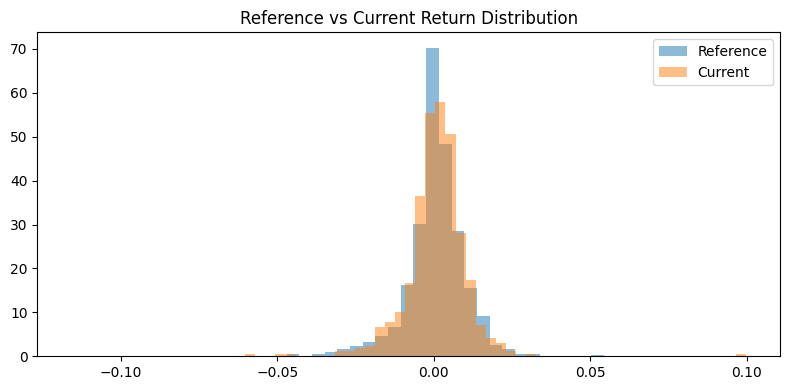

In [2]:
"""
Level-50 — Drift Detection (PSI/KS) + Auto-Retrain

Description:
    Monitor feature and label drift between an old "reference" period and a
    recent "current" period using:
      - Population Stability Index (PSI) for feature distributions
      - Kolmogorov-Smirnov (KS) tests for features and labels

    If drift exceeds thresholds, flag that the predictive model should be
    retrained on fresher data. This is a key piece of *ML monitoring* for
    real-time quant research pipelines.

Objective:
    - Provide a light-weight, fully Python-only drift monitor for price-based
      features and binary labels (trend up/down).
    - Integrate naturally into your existing time-series modeling workflow.

DSA Concept (detailed):
    1) Sliding Windows / Two Segments:
       We split a time series (T days) into two contiguous windows:
            reference = first N_ref days
            current   = last  N_cur days
       This is just slicing an array into two segments, a classic DSA pattern
       for window-based analytics (prefix vs suffix).

    2) Histogram Bucketing + PSI:
       For each feature X, we:
         - Choose bin edges on the reference data only (percentiles).
         - Use np.histogram to count how many points fall in each bin for
           reference and current.
         - Convert counts to proportions p_ref, p_cur.
         - Compute Population Stability Index:
               PSI = Σ (p_ref - p_cur) * ln(p_ref / p_cur)
           This is "bucketization + aggregation" — i.e. a histogram-based
           approximation of the underlying distribution. In DSA terms, this
           is repeated use of:
             - Sorting (to pick quantile-based bin edges),
             - Counting (linear scan with bins),
             - Scalar algebra over bins.

    3) Two-sample KS Test (CDF-based, two-pointer pattern):
       For each feature, the KS test compares the empirical CDFs of reference
       and current samples. Conceptually:
         - Sort both sets (O(n log n) + O(m log m)).
         - Walk two pointers i, j over the sorted arrays:
             while i < n or j < m:
                 update F_ref and F_cur at each unique value
                 track max |F_ref - F_cur|
         - The maximum gap is the KS statistic.
       The built-in SciPy implementation does this under the hood. It's a
       classic merge-like, two-pointer DSA pattern on sorted arrays.

    4) Time-ordered Train/Test Split:
       For the model we fit (simple logistic regression), we use:
           train = first 70%
           test  = last 30%
       This is prefix/suffix slicing again, preserving time order and avoiding
       label leakage. DSA-wise, it's just manipulating index ranges.

Real-Time Implementation Scope:
    - Run this after each daily/weekly retrain or as a scheduled job.
    - Use last X days as "current", previous Y days as "reference".
    - If drift>threshold, trigger an automated model retrain.

Free Data/APIs:
    - yfinance for underlying price data
    - Fully synthetic fallback (sin + noise) if yfinance fails (e.g., no internet).

Deliverables:
    - level50_drift_features.csv : features & drift scores
    - level50_drift_labels.csv   : labels and KS metrics
    - level50_drift_metrics.json : summary metrics + 'RETRAIN_REQUIRED' flag
    - Optional matplotlib plot of reference vs current returns.

Difficulty: Intermediate
Build Time: ~3 hours (including experiments & tuning)

External Reading / Usage Examples (non-exhaustive):
    # (These are for your own study, NOT required by this code.)

    - General concept of PSI in credit risk / model monitoring:
      https://cran.r-project.org/web/packages/creditmodel/vignettes/PSI.html
    - Practical PSI + KS drift monitoring discussion (blog):
      https://towardsdatascience.com/data-drift-detection-with-population-stability-index-psi-704acb88a95f
    - Model monitoring & drift (sklearn + time series):
      https://scikit-learn.org/stable/auto_examples/applications/plot_model_complexity_influence.html
"""

from __future__ import annotations

import json
from dataclasses import dataclass, asdict
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score


# --------------------------- Config --------------------------- #

@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2015-01-01"

    # Windowing for drift (fractions of the full history)
    ref_frac: float = 0.6   # first 60% of samples
    cur_frac: float = 0.2   # last 20% of samples (middle is for model training)

    # PSI / KS parameters
    n_bins: int = 10
    psi_threshold: float = 0.25   # rule-of-thumb: >0.25 = significant drift
    ks_alpha: float = 0.05        # significance level for KS tests

    # Labeling: horizon for "up / down" trend label
    label_horizon: int = 5

    # Output files
    out_features_csv: str = "level50_drift_features.csv"
    out_labels_csv: str = "level50_drift_labels.csv"
    out_metrics_json: str = "level50_drift_metrics.json"


# --------------------------- Utilities --------------------------- #

def generate_synthetic(cfg: Config, n: int = 1500) -> pd.DataFrame:
    """
    Generate a synthetic price series if yfinance is unavailable.

    We create a gently trending 'price' using a random walk plus a
    low-frequency sinusoid and noise.
    """
    idx = pd.date_range(cfg.start, periods=n, freq="B")
    rng = np.random.default_rng(42)
    steps = rng.normal(loc=0.0003, scale=0.01, size=n)  # drift + noise
    price = 100 + np.cumsum(steps)
    price = np.maximum(price, 1.0)  # no non-positive prices

    df = pd.DataFrame({"close": price}, index=idx)
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna()
    return df


def load_price_series(cfg: Config) -> pd.DataFrame:
    """
    Download daily adjusted close prices from yfinance and compute log returns.
    Fallback to synthetic data if download fails or returns empty.

    This is now defensive against:
      - plain DataFrame
      - Series
      - MultiIndex columns
      - 2D (n, 1) shapes
    """
    try:
        px = yf.download(
            cfg.symbol,
            start=cfg.start,
            auto_adjust=True,
            progress=False
        )
    except Exception:
        px = pd.DataFrame()

    if px is None or px.empty:
        print("[WARN] yfinance download failed or empty; using synthetic series.")
        return generate_synthetic(cfg)

    # Case 1: yfinance gave a Series (rare but possible)
    if isinstance(px, pd.Series):
        close = px.astype(float).rename("close")

    else:
        # Case 2: yfinance gave a DataFrame
        close_obj = None

        # (a) Simple columns with 'Close' present
        if "Close" in px.columns:
            close_obj = px["Close"]

        # (b) If 'Close' not present but MultiIndex columns
        elif isinstance(px.columns, pd.MultiIndex):
            # Try ('Close', symbol) first
            if ("Close", cfg.symbol) in px.columns:
                close_obj = px[("Close", cfg.symbol)]
            else:
                # Otherwise take the first column under 'Close'
                try:
                    sub = px.xs("Close", axis=1, level=0)
                    close_obj = sub.iloc[:, 0]
                except Exception:
                    # Last resort: just take the first column overall
                    close_obj = px.iloc[:, 0]

        # (c) Fallback: first column
        if close_obj is None:
            close_obj = px.iloc[:, 0]

        # Ensure we end up with a 1D Series
        if isinstance(close_obj, pd.DataFrame):
            close_obj = close_obj.iloc[:, 0]

        # At this point close_obj should be a Series-like; flatten if needed
        arr = np.asarray(close_obj).reshape(-1)
        close = pd.Series(arr, index=px.index, name="close").astype(float)

    df = pd.DataFrame({"close": close})
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna()
    return df


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a small feature set from returns:
        - rolling volatility (20, 60, 120 days)
        - rolling mean return (20 days)
        - rolling downside volatility (20 days)
    """
    r = df["ret"]

    feat = pd.DataFrame(index=df.index)
    feat["ret"] = r
    feat["vol_20"] = r.rolling(20).std()
    feat["vol_60"] = r.rolling(60).std()
    feat["vol_120"] = r.rolling(120).std()
    feat["mean_20"] = r.rolling(20).mean()

    # downside volatility: std of negative returns only
    neg_r = r.where(r < 0.0, 0.0)
    feat["down_vol_20"] = neg_r.rolling(20).std()

    feat = feat.dropna()
    return feat


def build_labels(df: pd.DataFrame, horizon: int) -> pd.Series:
    """
    Simple trend label: +1 if price horizon days ahead is higher than today,
    else 0 (down/flat).
    """
    close = df["close"]
    future_close = close.shift(-horizon)
    label = (future_close > close).astype(int)
    label = label.dropna()
    return label


# --------------------------- DSA: PSI Computation --------------------------- #

def compute_psi(
    ref: np.ndarray,
    cur: np.ndarray,
    n_bins: int
) -> float:
    """
    Compute Population Stability Index between a reference sample and
    a current sample.

    Steps (DSA friendly):
        1. Build bin edges from percentiles of reference.
        2. Count observations in each bin for ref and cur (np.histogram).
        3. Convert to proportions (p_ref, p_cur).
        4. PSI = Σ (p_ref - p_cur) * ln(p_ref / p_cur).

    We add a small epsilon to avoid log(0) and division by zero.
    """
    ref = np.asarray(ref, dtype=float)
    cur = np.asarray(cur, dtype=float)

    ref = ref[np.isfinite(ref)]
    cur = cur[np.isfinite(cur)]

    if ref.size == 0 or cur.size == 0:
        return np.nan

    # Build bins on ref only, ignoring extreme outliers via percentiles
    pct = np.linspace(0, 100, n_bins + 1)
    bins = np.percentile(ref, pct)
    # Deduplicate edges if needed (can happen with flat distributions)
    bins = np.unique(bins)
    if bins.size < 2:
        return 0.0

    ref_hist, _ = np.histogram(ref, bins=bins)
    cur_hist, _ = np.histogram(cur, bins=bins)

    ref_prop = ref_hist.astype(float) / np.maximum(ref_hist.sum(), 1.0)
    cur_prop = cur_hist.astype(float) / np.maximum(cur_hist.sum(), 1.0)

    eps = 1e-6
    ref_prop = np.clip(ref_prop, eps, 1.0)
    cur_prop = np.clip(cur_prop, eps, 1.0)

    psi_vals = (ref_prop - cur_prop) * np.log(ref_prop / cur_prop)
    psi = float(np.sum(psi_vals))
    return psi


# --------------------------- Drift Calculation --------------------------- #

def compute_feature_drift(
    feat: pd.DataFrame,
    ref_idx: pd.Index,
    cur_idx: pd.Index,
    cfg: Config
) -> pd.DataFrame:
    """
    For each feature column, compute:
        - PSI(ref, cur)
        - KS statistic + p-value (two-sample KS test)
    """
    rows = []
    for col in feat.columns:
        ref_vals = feat.loc[ref_idx, col].values
        cur_vals = feat.loc[cur_idx, col].values

        psi_val = compute_psi(ref_vals, cur_vals, cfg.n_bins)

        # KS test (we use 'nan_policy' by dropping NaNs beforehand)
        ref_clean = ref_vals[np.isfinite(ref_vals)]
        cur_clean = cur_vals[np.isfinite(cur_vals)]
        if ref_clean.size > 0 and cur_clean.size > 0:
            ks_stat, ks_p = ks_2samp(ref_clean, cur_clean)
        else:
            ks_stat, ks_p = np.nan, np.nan

        rows.append({
            "feature": col,
            "psi": psi_val,
            "ks_stat": ks_stat,
            "ks_pvalue": ks_p
        })

    out = pd.DataFrame(rows)
    return out


def compute_label_drift(
    labels: pd.Series,
    ref_idx: pd.Index,
    cur_idx: pd.Index
) -> Dict[str, float]:
    """
    Compute label distribution (share of 1s) in reference vs current and
    a KS test on the label values (works for binary but also non-binary).
    """
    y_ref = labels.loc[labels.index.intersection(ref_idx)].values
    y_cur = labels.loc[labels.index.intersection(cur_idx)].values

    y_ref = y_ref[np.isfinite(y_ref)]
    y_cur = y_cur[np.isfinite(y_cur)]

    if y_ref.size == 0 or y_cur.size == 0:
        return {
            "label_share_ref": np.nan,
            "label_share_cur": np.nan,
            "label_ks_stat": np.nan,
            "label_ks_pvalue": np.nan
        }

    share_ref = float(np.mean(y_ref))
    share_cur = float(np.mean(y_cur))

    ks_stat, ks_p = ks_2samp(y_ref, y_cur)
    return {
        "label_share_ref": share_ref,
        "label_share_cur": share_cur,
        "label_ks_stat": float(ks_stat),
        "label_ks_pvalue": float(ks_p),
    }


# --------------------------- Model Training (for context) --------------------------- #

def train_simple_model(
    feat: pd.DataFrame,
    labels: pd.Series
) -> Dict[str, float]:
    """
    Train a simple logistic regression on the middle chunk of the data
    (after the reference window, before the current window) and compute
    basic performance metrics on a time-ordered train/test split.

    This is not a fancy model; it's just here to demonstrate how drift
    metrics can be tied back to a real classifier.
    """
    # Align indices
    aligned_idx = feat.index.intersection(labels.index)
    X = feat.loc[aligned_idx]
    y = labels.loc[aligned_idx]

    if X.shape[0] < 200:
        return {"auc": np.nan, "acc": np.nan}

    split_idx = int(0.7 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    model = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )
    model.fit(X_train, y_train)

    prob = model.predict_proba(X_test)[:, 1]
    pred = (prob >= 0.5).astype(int)

    auc = float(roc_auc_score(y_test, prob))
    acc = float(accuracy_score(y_test, pred))

    return {"auc": auc, "acc": acc}


# --------------------------- Orchestration --------------------------- #

def split_windows(idx: pd.Index, cfg: Config) -> Tuple[pd.Index, pd.Index]:
    """
    Given an index of length N, define:
        - reference window: first floor(ref_frac * N)
        - current window:   last  floor(cur_frac * N)

    The middle is implicitly reserved for model training if desired.
    """
    n = len(idx)
    if n < 100:
        raise RuntimeError("Not enough data for drift windows; need at least 100 observations.")

    n_ref = int(cfg.ref_frac * n)
    n_cur = int(cfg.cur_frac * n)
    if n_ref + n_cur > n:
        raise RuntimeError("ref_frac + cur_frac must be <= 1.0.")

    ref_idx = idx[:n_ref]
    cur_idx = idx[-n_cur:]
    return ref_idx, cur_idx


def save_outputs(
    feat_drift: pd.DataFrame,
    labels: pd.Series,
    label_drift: Dict[str, float],
    model_metrics: Dict[str, float],
    cfg: Config
) -> None:
    """
    Save CSV/JSON outputs for downstream analysis.
    """
    # Features + drift metrics
    feat_drift.to_csv(cfg.out_features_csv, index=False)

    # Labels per date
    labels_df = pd.DataFrame({"label": labels})
    labels_df.to_csv(cfg.out_labels_csv, index_label="date")

    # Metrics to JSON
    metrics = {
        "psi_threshold": cfg.psi_threshold,
        "ks_alpha": cfg.ks_alpha,
        "max_feature_psi": float(feat_drift["psi"].max(skipna=True)),
        "n_features_psi_over_threshold": int((feat_drift["psi"] > cfg.psi_threshold).sum()),
    }
    metrics.update(label_drift)
    metrics.update(model_metrics)

    # Simple auto-retrain flag:
    retrain_required = (
        metrics["max_feature_psi"] > cfg.psi_threshold
        or (metrics.get("label_ks_pvalue") is not None
            and not np.isnan(metrics["label_ks_pvalue"])
            and metrics["label_ks_pvalue"] < cfg.ks_alpha)
    )
    metrics["RETRAIN_REQUIRED"] = bool(retrain_required)

    with open(cfg.out_metrics_json, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)


def plot_ref_vs_cur_returns(df: pd.DataFrame, ref_idx: pd.Index, cur_idx: pd.Index) -> None:
    """
    Optional helper: plot reference vs current return distributions
    for quick visual check.
    """
    r_ref = df.loc[ref_idx, "ret"]
    r_cur = df.loc[cur_idx, "ret"]

    plt.figure(figsize=(8, 4))
    plt.hist(r_ref, bins=50, alpha=0.5, label="Reference", density=True)
    plt.hist(r_cur, bins=50, alpha=0.5, label="Current", density=True)
    plt.title("Reference vs Current Return Distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()


def run_pipeline(cfg: Config) -> None:
    """
    Main orchestration:
        1) Load price data (with synthetic fallback).
        2) Build features & labels.
        3) Define reference and current windows.
        4) Compute feature drift (PSI + KS).
        5) Compute label drift.
        6) Train a simple model and get metrics.
        7) Save outputs and print a quick summary.
    """
    print(f"[INFO] Loading price series for {cfg.symbol} from {cfg.start} ...")
    df = load_price_series(cfg)
    print(f"[INFO] Got {len(df)} daily observations.")

    feat = build_features(df)
    labels = build_labels(df, cfg.label_horizon)

    # Align features & labels to a common index for drift
    common_idx = feat.index.intersection(labels.index)
    feat = feat.loc[common_idx]
    labels = labels.loc[common_idx]

    ref_idx, cur_idx = split_windows(common_idx, cfg)
    print(f"[INFO] Reference window: {ref_idx[0].date()} → {ref_idx[-1].date()} "
          f"({len(ref_idx)} obs)")
    print(f"[INFO] Current window:   {cur_idx[0].date()} → {cur_idx[-1].date()} "
          f"({len(cur_idx)} obs)")

    # Feature drift
    feat_drift = compute_feature_drift(feat, ref_idx, cur_idx, cfg)

    # Label drift
    label_drift = compute_label_drift(labels, ref_idx, cur_idx)

    # Simple model metrics
    model_metrics = train_simple_model(feat, labels)

    # Save everything
    save_outputs(feat_drift, labels, label_drift, model_metrics, cfg)

    print("\n[SUMMARY] Feature Drift (top 5 by PSI):")
    print(feat_drift.sort_values("psi", ascending=False).head())

    print("\n[SUMMARY] Label Drift:")
    for k, v in label_drift.items():
        print(f"  {k}: {v}")

    print("\n[SUMMARY] Model Metrics:")
    for k, v in model_metrics.items():
        print(f"  {k}: {v}")

    # Load metrics JSON just to display RETRAIN_REQUIRED
    with open(cfg.out_metrics_json, "r", encoding="utf-8") as f:
        metrics = json.load(f)
    print(f"\n[SUMMARY] RETRAIN_REQUIRED: {metrics['RETRAIN_REQUIRED']}")

    # Optional: quick visual check
    try:
        plot_ref_vs_cur_returns(df, ref_idx, cur_idx)
    except Exception as e:
        print(f"[WARN] Plot failed: {e}")


# --------------------------- Script Entrypoint --------------------------- #

if __name__ == "__main__":
    # Jupyter-safe argv cleanup: drop "-f <kernel>.json" if present
    import sys
    if len(sys.argv) > 1:
        sys.argv = [sys.argv[0]]

    cfg = Config()
    run_pipeline(cfg)
